In [2]:
# Make sure the runtime is on GPU
# Download the common libraries
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [3]:
# Download the subset dataset
#!git clone https://github.com/parth1620/Person-Re-Id-Dataset

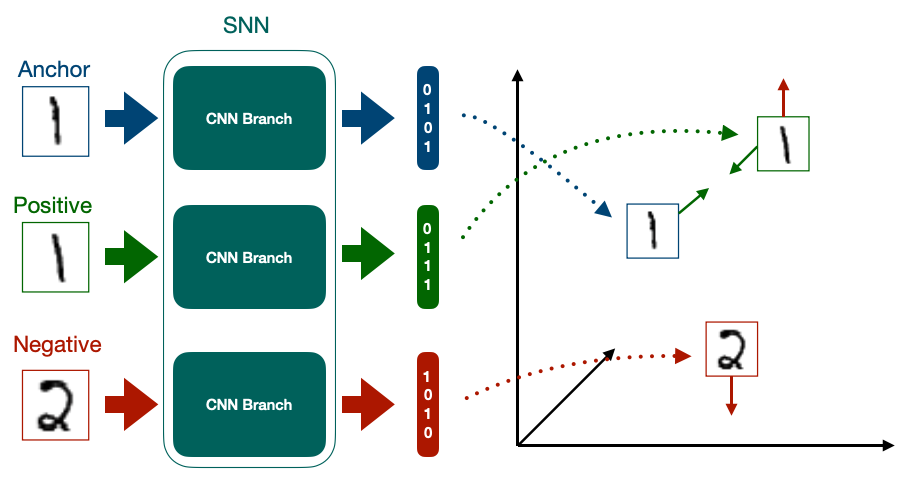

# Imports

In [4]:
# import sys
# sys.path.append('/content/Person-Re-Id-Dataset')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import os

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

C:\Users\slu810\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations配置

定义了一些用于设置和训练Siamese网络的基本参数和变量

In [6]:
# `train` file contains the images
# `utils.py` file contains the visualization functions

# Definition
DATA_DIR = 'E:\\slu810\\extracted_images_all\\' # 数据集目标路径
CSV_FILE = 'E:\slu810\extracted_images_all.csv'  # 数据集信息csv文件路径

BATCH_SIZE = 8 # 每批次用于训练的样本数量
LR = 0.001 # Learning rate
EPOCHS = 150 # 训练过程数据被遍历的次数

DEVICE = 'cuda' # We are on the GPU device

读数据

In [7]:
# Read the `extracted_images.csv` file
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Positive,Negative
0,0_1198_22-10-20_C2_06.jpg,0_2995_22-10-20_C2_06.jpg,2_7787_22-10-20_C2_06.jpg
1,0_1198_22-10-20_C2_06.jpg,0_3594_22-10-20_C2_06.jpg,5_599_22-10-20_C2_06.jpg
2,0_1198_22-10-20_C2_06.jpg,0_4193_22-10-20_C2_06.jpg,1_8386_22-10-20_C2_06.jpg
3,0_1198_22-10-20_C2_06.jpg,0_4792_22-10-20_C2_06.jpg,7_16772_22-10-20_C2_06.jpg
4,0_1198_22-10-20_C2_06.jpg,0_5391_22-10-20_C2_06.jpg,12_9584_22-10-20_C2_06.jpg


从DataFrame中读取图像文件的路径，并加载这些图像

In [8]:
# Read the images
row = df.iloc[4] # read the example number 4

A_img = io.imread(os.path.join(DATA_DIR + row.Anchor))
P_img = io.imread(os.path.join(DATA_DIR + row.Positive))
N_img = io.imread(os.path.join(DATA_DIR + row.Negative))

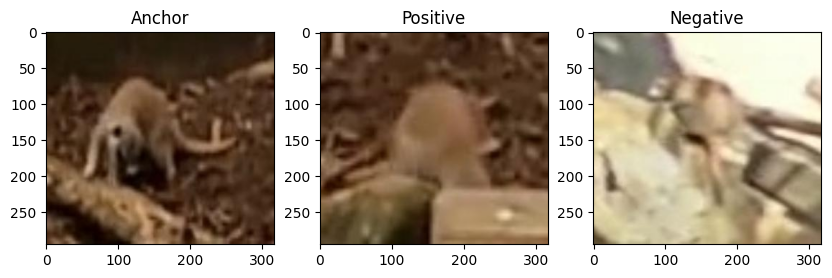

In [9]:
# Plot the images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5)) # plot a subplot

ax1.set_title("Anchor")
ax1.imshow(A_img) # Plot the Anchor image

ax2.set_title("Positive")
ax2.imshow(P_img) # Plot the Positive image

ax3.set_title("Negative")
ax3.imshow(N_img) # Plot the Negative image

In [10]:
# Split dataset into training and validation
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42) # test size is 20%

# Create APN Dataset -- a custom dataset

In [11]:
# Define a class which has three methods
class APN_Dataset(Dataset): # inherite from class `Dataset`

  def __init__(self, df): # init method - pass our dataframe
    self.df = df

  def __len__(self): # length method - return the size of the dataset
    return len(self.df)

  def __getitem__ (self, idx): #get item method - return the anchor positive and negative image according to the given

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)


    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

获取项目方法'__getitem__'

def __getitem__(self, idx): 定义了如何根据索引 idx 获取数据。这使得你可以像这样访问数据集的项目：dataset[idx]。

row = self.df.iloc[idx] 从 dataframe 中获取第 idx 行的数据。

接下来，使用 io.imread 函数从 DATA_DIR 加载与该行相关的三个图像（Anchor, Positive, Negative）。

图像数据从形状 (Height, Width, Channels) 转化为 (Channels, Height, Width)，这是 PyTorch 中常见的格式。此外，图像数据被归一化，除以 255，将像素值从 [0, 255] 转化为 [0, 1]。

return A_img, P_img, N_img 返回这三个处理后的图像。

在这样的任务中，模型的目标是确保锚点图像与正图像更相似，而与负图像更不相似。

In [12]:
# Creating instance
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

# Print the size of dataset
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 85668
Size of validset : 21418


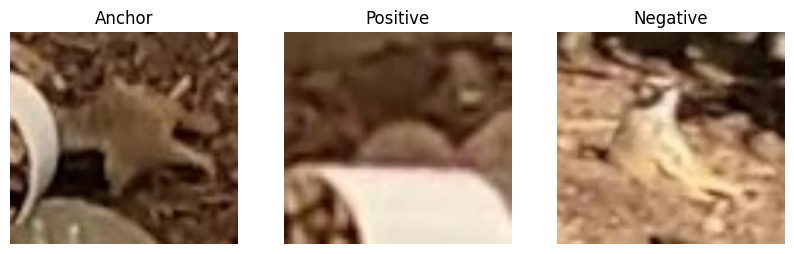

In [15]:
# Plot the images
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.axis('off')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.axis('off')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.axis('off')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
# Create train loader and valid loader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

以上代码的目的是使用PyTorch中的DataLoader类，为训练集和验证集创建数据加载器。数据加载器可迭代，允许批量、乱序和并行加载数据。

创建数据加载器:

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True):

- trainset 是我们要加载的数据集。

- batch_size = BATCH_SIZE 表示每个批次要加载的数据项数量。这里使用了一个名为 BATCH_SIZE 的变量，这个变量需要在其他地方被定义并赋值。

- shuffle = True 表示在每个训练时代开始之前，都将对数据进行乱序处理。这对于训练通常是有用的，因为它可以帮助模型更好地泛化，并避免某些固定的数据排序引起的问题。

validloader = DataLoader(validset, batch_size = BATCH_SIZE):

- 这是为验证集创建的加载器。
- 通常，验证过程不需要数据乱序，因此这里没有指定shuffle参数（默认为False）。

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10709
No. of batches in validloader : 2678


In [15]:
# Print one image shape from the data loader
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([8, 3, 295, 317])


# Create Model

APN_Model 的神经网络模型继承自PyTorch的 nn.Module 

使用 timm 库创建一个预训练的 efficientnet_b4 模型。这是一个现成的高效网络，已经在大型图像数据集上预训练过，能够提取图像的有效特征。

目的：生成输入图像的嵌入表示



In [16]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b4', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings

In [17]:
model = APN_Model()
model.to(DEVICE);

In [ ]:
# Define a class which has three methods
class APN_Dataset(Dataset): # inherite from class `Dataset`

  def __init__(self, df): # init method - pass our dataframe
    self.df = df

  def __len__(self): # length method - return the size of the dataset
    return len(self.df)

  def __getitem__ (self, idx): #get item method - return the anchor positive and negative image according to the given

    row = self.df.iloc[idx]

    #Import video to shape (frames, height, width, channels)
    A_img = io.imread(DATA_DIR + row.Anchor)    #TODO Change to video read
    P_img = io.imread(DATA_DIR + row.Positive)  #TODO Change to video read
    N_img = io.imread(DATA_DIR + row.Negative)  #TODO Change to video read


    A_img = torch.from_numpy(A_img).permute(0, 3, 1, 2) / 255.0
    P_img = torch.from_numpy(P_img).permute(0, 3, 1, 2) / 255.0
    N_img = torch.from_numpy(N_img).permute(0, 3, 1, 2) / 255.0

    return A_img, P_img, N_img

def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    
    #A, P, N should all be the same shape
    A_embs, P_embs, N_embs = [], [], []
    for f in range(A.shape[0]):
      A_embs += [model(A[f,...])]
      P_embs += [model(P[f,...])]
      N_embs += [model(N[f,...])]

    print(A_embs[0].shape())
    A_embs = np.average(np.asarray(A_embs), axis=0) #You could try np.max
    P_embs = np.average(np.asarray(P_embs), axis=0) #Might be axis = 1
    N_embs = np.average(np.asarray(N_embs), axis=0)
    print(A_embs.shape(), "Should be equal to above")

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

CSV_FILE = "" #TODO
df = pd.read_csv(CSV_FILE)

trainset = APN_Dataset(train_df)
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)

criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

train_losses = []
valid_losses = []

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    #valid_loss = eval_fn(model, validloader, criterion)
    
    # 添加损失到列表中
    train_losses.append(train_loss)
    #valid_losses.append(valid_loss)

    # if valid_loss < best_valid_loss:
    #     torch.save(model.state_dict(), 'best_model.pt')
    #     best_valid_loss = valid_loss

# Create Train and Eval function

model: 要训练的神经网络模型。
dataloader: 提供训练数据的DataLoader，它会批量地提供锚定图像（A）、正样本图像（P）和负样本图像（N）。
optimizer: 用于更新模型权重的优化器。
criterion: 计算损失的函数，用于评估模型的输出与目标之间的差异。

In [18]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [19]:
def eval_fn(model, dataloader, criterion):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():

    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)


      total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [21]:
# # 1. 初始化一个DataFrame来存储损失数据
# loss_df = pd.DataFrame(columns=['epoch', 'train_loss', 'valid_loss'])

# best_valid_loss = np.Inf


# for i in range(EPOCHS):

#   train_loss = train_fn(model, trainloader, optimizer, criterion)
#   valid_loss = eval_fn(model, validloader, criterion)

#   # 2. 在每个epoch的结束，将新的数据添加到DataFrame
#   new_row = {'epoch': i+1, 'train_loss': train_loss, 'valid_loss': valid_loss}
#   loss_df = loss_df.append(new_row, ignore_index=True)

#   if valid_loss < best_valid_loss:
#     torch.save(model.state_dict(), 'best_model.pt')
#     best_valid_loss = valid_loss
#     print("SAVED_WEIGHTS_SUCCESS")

#   print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


# # 3. 将数据保存到CSV文件
# loss_df.to_csv('training_loss_data.csv', index=False)

# # 4. 绘制损失曲线图
# plt.figure(figsize=(12, 6))
# plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train Loss')
# plt.plot(loss_df['epoch'], loss_df['valid_loss'], label='Valid Loss', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.legend()
# plt.show()

100%|██████████| 2678/2678 [08:51<00:00,  5.04it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.3826381561454799 valid_loss : 0.8471038453809533


100%|██████████| 2678/2678 [08:46<00:00,  5.09it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.2169079976287673 valid_loss : 0.8192386144996134


100%|██████████| 2678/2678 [08:52<00:00,  5.03it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.14458443664271065 valid_loss : 0.6860937808513018


100%|██████████| 2678/2678 [11:22<00:00,  3.93it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.1075827222429122 valid_loss : 0.6451476282475598


100%|██████████| 2678/2678 [08:28<00:00,  5.27it/s]


EPOCHS : 5 train_loss : 0.08549667581483111 valid_loss : 0.6863178771609597


100%|██████████| 2678/2678 [08:58<00:00,  4.97it/s]


EPOCHS : 6 train_loss : 0.08090243537181765 valid_loss : 0.7200380394303416


100%|██████████| 2678/2678 [08:56<00:00,  4.99it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.07118666718315372 valid_loss : 0.613952725775167


100%|██████████| 2678/2678 [08:55<00:00,  5.00it/s]


EPOCHS : 8 train_loss : 0.06599536338449359 valid_loss : 0.6942055708519375


100%|██████████| 2678/2678 [08:39<00:00,  5.16it/s]


EPOCHS : 9 train_loss : 0.060804805449549366 valid_loss : 0.6201642745461724


100%|██████████| 2678/2678 [08:33<00:00,  5.22it/s]


EPOCHS : 10 train_loss : 0.05515885667419532 valid_loss : 0.6983898288060517


100%|██████████| 2678/2678 [08:47<00:00,  5.07it/s]


EPOCHS : 11 train_loss : 0.05618561931613313 valid_loss : 0.7169478743979074


100%|██████████| 2678/2678 [08:10<00:00,  5.46it/s]


EPOCHS : 12 train_loss : 0.045025632283535975 valid_loss : 0.6399896383296652


100%|██████████| 2678/2678 [08:13<00:00,  5.42it/s]


EPOCHS : 13 train_loss : 0.04373829844162927 valid_loss : 0.6161036814122702


100%|██████████| 2678/2678 [08:14<00:00,  5.42it/s]


EPOCHS : 14 train_loss : 0.04371466247410275 valid_loss : 0.6451919637759557


100%|██████████| 2678/2678 [08:08<00:00,  5.49it/s]


EPOCHS : 15 train_loss : 0.04169868361644912 valid_loss : 0.643776988197477


100%|██████████| 2678/2678 [08:39<00:00,  5.16it/s]


EPOCHS : 16 train_loss : 0.03803013721253983 valid_loss : 0.6986110612883596


100%|██████████| 2678/2678 [08:44<00:00,  5.10it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 17 train_loss : 0.03895470538814146 valid_loss : 0.5643008378034567


100%|██████████| 2678/2678 [08:41<00:00,  5.13it/s]


EPOCHS : 18 train_loss : 0.03815701049948642 valid_loss : 0.6703210410796234


100%|██████████| 2678/2678 [08:52<00:00,  5.03it/s]


EPOCHS : 19 train_loss : 0.03451500925288413 valid_loss : 0.6214052008560916


100%|██████████| 2678/2678 [08:46<00:00,  5.09it/s]


EPOCHS : 20 train_loss : 0.036812980789320736 valid_loss : 0.6090358448137625


100%|██████████| 2678/2678 [08:42<00:00,  5.13it/s]


EPOCHS : 21 train_loss : 0.03171394076881895 valid_loss : 0.606330974638195


100%|██████████| 2678/2678 [08:44<00:00,  5.11it/s]


EPOCHS : 22 train_loss : 0.03244470177171878 valid_loss : 0.6043419695005121


100%|██████████| 2678/2678 [08:13<00:00,  5.43it/s]


EPOCHS : 23 train_loss : 0.029762169422917657 valid_loss : 0.7779353315690901


100%|██████████| 2678/2678 [08:46<00:00,  5.09it/s]


EPOCHS : 24 train_loss : 0.029723442482151273 valid_loss : 0.6689014921467014


100%|██████████| 2678/2678 [08:09<00:00,  5.47it/s]


EPOCHS : 25 train_loss : 0.03167275774683735 valid_loss : 0.5710235949747593


100%|██████████| 2678/2678 [08:20<00:00,  5.35it/s]


EPOCHS : 26 train_loss : 0.025733811106821193 valid_loss : 0.5782248455811295


100%|██████████| 2678/2678 [08:33<00:00,  5.21it/s]


EPOCHS : 27 train_loss : 0.028370290447799797 valid_loss : 0.6854017984909384


100%|██████████| 2678/2678 [08:38<00:00,  5.16it/s]


EPOCHS : 28 train_loss : 0.026198116875471817 valid_loss : 0.6024865406642572


100%|██████████| 2678/2678 [08:42<00:00,  5.12it/s]


EPOCHS : 29 train_loss : 0.024316740568662204 valid_loss : 0.7190564443385806


100%|██████████| 2678/2678 [08:45<00:00,  5.10it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 30 train_loss : 0.02485945537089411 valid_loss : 0.5384977818080701


100%|██████████| 2678/2678 [08:57<00:00,  4.98it/s]


EPOCHS : 31 train_loss : 0.025525821145536608 valid_loss : 0.7499647185573656


100%|██████████| 2678/2678 [08:52<00:00,  5.03it/s]


EPOCHS : 32 train_loss : 0.020449929165454992 valid_loss : 0.6579757912322334


100%|██████████| 2678/2678 [09:03<00:00,  4.93it/s]


EPOCHS : 33 train_loss : 0.022947648708332106 valid_loss : 0.6504251442910843


100%|██████████| 2678/2678 [08:41<00:00,  5.14it/s]


EPOCHS : 34 train_loss : 0.022767715645177055 valid_loss : 0.5475825327292051


100%|██████████| 2678/2678 [08:02<00:00,  5.55it/s]


EPOCHS : 35 train_loss : 0.021827464659058844 valid_loss : 0.5759230165772246


100%|██████████| 2678/2678 [08:14<00:00,  5.42it/s]


EPOCHS : 36 train_loss : 0.021888008462424283 valid_loss : 1.0048781048125344


100%|██████████| 2678/2678 [08:26<00:00,  5.29it/s]


EPOCHS : 37 train_loss : 0.023629015098879103 valid_loss : 0.6737666835728824


100%|██████████| 2678/2678 [08:21<00:00,  5.34it/s]


EPOCHS : 38 train_loss : 0.01994061743453923 valid_loss : 0.6250139314339088


100%|██████████| 2678/2678 [08:24<00:00,  5.31it/s]


EPOCHS : 39 train_loss : 0.02186883340636403 valid_loss : 0.5688737311843529


100%|██████████| 2678/2678 [08:39<00:00,  5.15it/s]


EPOCHS : 40 train_loss : 0.02441238943034833 valid_loss : 0.7573595626795799


100%|██████████| 2678/2678 [08:52<00:00,  5.03it/s]


EPOCHS : 41 train_loss : 0.02183164169011591 valid_loss : 0.5530404924700917


100%|██████████| 2678/2678 [08:54<00:00,  5.01it/s]


EPOCHS : 42 train_loss : 0.021709708282121345 valid_loss : 0.6167016008992618


100%|██████████| 2678/2678 [08:49<00:00,  5.06it/s]


EPOCHS : 43 train_loss : 0.018604326369504386 valid_loss : 0.733582808376694


100%|██████████| 2678/2678 [08:45<00:00,  5.09it/s]


EPOCHS : 44 train_loss : 0.020842452951590325 valid_loss : 0.54437382477513


100%|██████████| 2678/2678 [08:45<00:00,  5.09it/s]


EPOCHS : 45 train_loss : 0.019559288661635126 valid_loss : 0.5780322467706558


100%|██████████| 2678/2678 [08:38<00:00,  5.17it/s]


EPOCHS : 46 train_loss : 0.020443324799385824 valid_loss : 0.5462955628438971


100%|██████████| 2678/2678 [09:21<00:00,  4.77it/s]


EPOCHS : 47 train_loss : 0.017376560010610814 valid_loss : 0.5651838640898711


100%|██████████| 2678/2678 [08:39<00:00,  5.16it/s]


EPOCHS : 48 train_loss : 0.020466603997575435 valid_loss : 0.6473192621781988


100%|██████████| 2678/2678 [08:14<00:00,  5.42it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 49 train_loss : 0.01583428891285738 valid_loss : 0.5157899691808838


100%|██████████| 2678/2678 [08:26<00:00,  5.29it/s]


EPOCHS : 50 train_loss : 0.01643123944463132 valid_loss : 0.5180166366053126


100%|██████████| 2678/2678 [08:21<00:00,  5.34it/s]


EPOCHS : 51 train_loss : 0.019142034967380452 valid_loss : 0.8059498842379956


100%|██████████| 2678/2678 [08:34<00:00,  5.20it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 52 train_loss : 0.017948777475647815 valid_loss : 0.488707230724756


100%|██████████| 2678/2678 [08:41<00:00,  5.13it/s]


EPOCHS : 53 train_loss : 0.016958049232468395 valid_loss : 0.5766102591831351


100%|██████████| 2678/2678 [09:04<00:00,  4.92it/s]


EPOCHS : 54 train_loss : 0.01679392201842152 valid_loss : 0.5513322143811981


100%|██████████| 2678/2678 [08:54<00:00,  5.01it/s]


EPOCHS : 55 train_loss : 0.015013197708089808 valid_loss : 0.5545040038904653


100%|██████████| 2678/2678 [08:50<00:00,  5.05it/s]


EPOCHS : 56 train_loss : 0.016691438745902426 valid_loss : 0.5273585088211623


100%|██████████| 2678/2678 [09:03<00:00,  4.93it/s]


EPOCHS : 57 train_loss : 0.015172989885060545 valid_loss : 0.5891022395740435


100%|██████████| 2678/2678 [08:43<00:00,  5.11it/s]


EPOCHS : 58 train_loss : 0.01481616622410476 valid_loss : 0.6223168537810813


100%|██████████| 2678/2678 [08:34<00:00,  5.20it/s]


EPOCHS : 59 train_loss : 0.01451818785398923 valid_loss : 0.6164409801185888


100%|██████████| 2678/2678 [08:10<00:00,  5.46it/s]


EPOCHS : 60 train_loss : 0.017133972629555492 valid_loss : 0.5051769311411155


100%|██████████| 2678/2678 [08:27<00:00,  5.28it/s]


EPOCHS : 61 train_loss : 0.01681860074441254 valid_loss : 0.5337546619185323


100%|██████████| 2678/2678 [08:36<00:00,  5.19it/s]


EPOCHS : 62 train_loss : 0.013205596145900961 valid_loss : 0.7168693737341807


100%|██████████| 2678/2678 [09:08<00:00,  4.88it/s]


EPOCHS : 63 train_loss : 0.014972130393089172 valid_loss : 0.5466073639273554


100%|██████████| 2678/2678 [08:56<00:00,  4.99it/s]


EPOCHS : 64 train_loss : 0.012425359241467518 valid_loss : 0.5653207074681087


100%|██████████| 2678/2678 [08:50<00:00,  5.05it/s]


EPOCHS : 65 train_loss : 0.01379777054034625 valid_loss : 0.6000679404022001


100%|██████████| 2678/2678 [08:50<00:00,  5.04it/s]


EPOCHS : 66 train_loss : 0.013598852027240661 valid_loss : 0.586146889336524


100%|██████████| 2678/2678 [08:44<00:00,  5.10it/s]


EPOCHS : 67 train_loss : 0.012968465902912415 valid_loss : 0.5318248355573376


100%|██████████| 2678/2678 [08:48<00:00,  5.07it/s]


EPOCHS : 68 train_loss : 0.014417921381400117 valid_loss : 0.7294188703370682


100%|██████████| 2678/2678 [08:32<00:00,  5.22it/s]


EPOCHS : 69 train_loss : 0.013195068010073637 valid_loss : 0.5655126427039449


100%|██████████| 2678/2678 [08:35<00:00,  5.19it/s]


EPOCHS : 70 train_loss : 0.011024010805914922 valid_loss : 0.6488008832724527


100%|██████████| 2678/2678 [09:01<00:00,  4.94it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 71 train_loss : 0.012968958035015417 valid_loss : 0.4860930098547608


100%|██████████| 2678/2678 [09:46<00:00,  4.57it/s]


EPOCHS : 72 train_loss : 0.014904189839206364 valid_loss : 0.5974322555056697


100%|██████████| 2678/2678 [08:42<00:00,  5.12it/s]


EPOCHS : 73 train_loss : 0.012695264091054446 valid_loss : 0.6841514510081008


100%|██████████| 2678/2678 [08:16<00:00,  5.39it/s]


EPOCHS : 74 train_loss : 0.0102948408348797 valid_loss : 0.7144084212560098


100%|██████████| 2678/2678 [08:22<00:00,  5.33it/s]


EPOCHS : 75 train_loss : 0.013193776775546319 valid_loss : 0.5621894281121045


100%|██████████| 2678/2678 [08:22<00:00,  5.32it/s]


EPOCHS : 76 train_loss : 0.012096349395883218 valid_loss : 0.7368921531368495


100%|██████████| 2678/2678 [08:22<00:00,  5.33it/s]


EPOCHS : 77 train_loss : 0.01219158100140107 valid_loss : 0.49935139572669357


100%|██████████| 2678/2678 [08:32<00:00,  5.22it/s]


EPOCHS : 78 train_loss : 0.010846088333661533 valid_loss : 0.516195989071299


100%|██████████| 2678/2678 [08:47<00:00,  5.07it/s]


EPOCHS : 79 train_loss : 0.011606132624329434 valid_loss : 0.5706832125015096


100%|██████████| 2678/2678 [08:48<00:00,  5.06it/s]


EPOCHS : 80 train_loss : 0.012528994363032644 valid_loss : 0.5516989064181003


100%|██████████| 2678/2678 [08:45<00:00,  5.09it/s]


EPOCHS : 81 train_loss : 0.01220148630236386 valid_loss : 0.5448779537884311


100%|██████████| 2678/2678 [09:09<00:00,  4.88it/s]


EPOCHS : 82 train_loss : 0.012900839740015099 valid_loss : 0.5152189632497944


100%|██████████| 2678/2678 [08:44<00:00,  5.10it/s]


EPOCHS : 83 train_loss : 0.013984439203870297 valid_loss : 0.5276954358275299


100%|██████████| 2678/2678 [08:31<00:00,  5.23it/s]


EPOCHS : 84 train_loss : 0.009506483818928348 valid_loss : 0.52772989230894


100%|██████████| 2678/2678 [08:25<00:00,  5.29it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 85 train_loss : 0.011948346277669828 valid_loss : 0.4691703692245519


100%|██████████| 2678/2678 [08:19<00:00,  5.36it/s]


EPOCHS : 86 train_loss : 0.011331780320100395 valid_loss : 0.7157798312198235


100%|██████████| 2678/2678 [08:22<00:00,  5.33it/s]


EPOCHS : 87 train_loss : 0.00983890235418476 valid_loss : 0.5184423810259187


100%|██████████| 2678/2678 [08:13<00:00,  5.42it/s]


EPOCHS : 88 train_loss : 0.009472893790845188 valid_loss : 0.5723918497206294


100%|██████████| 2678/2678 [08:26<00:00,  5.29it/s]


EPOCHS : 89 train_loss : 0.009436558381395075 valid_loss : 0.6409064899737751


100%|██████████| 2678/2678 [08:18<00:00,  5.38it/s]


EPOCHS : 90 train_loss : 0.011128033392457626 valid_loss : 0.534504409976821


100%|██████████| 2678/2678 [08:38<00:00,  5.17it/s]


EPOCHS : 91 train_loss : 0.010184767412609475 valid_loss : 0.627082344575815


100%|██████████| 2678/2678 [09:00<00:00,  4.95it/s]


EPOCHS : 92 train_loss : 0.00833981416062688 valid_loss : 1.0976904836094494


100%|██████████| 2678/2678 [09:37<00:00,  4.64it/s]


EPOCHS : 93 train_loss : 0.011043864533406745 valid_loss : 0.9489676514786513


100%|██████████| 2678/2678 [08:54<00:00,  5.01it/s]


EPOCHS : 94 train_loss : 0.009462479817476556 valid_loss : 0.5313535312982172


100%|██████████| 2678/2678 [08:51<00:00,  5.03it/s]


EPOCHS : 95 train_loss : 0.007955488086425799 valid_loss : 0.9078077811349943


100%|██████████| 2678/2678 [09:04<00:00,  4.92it/s]


EPOCHS : 96 train_loss : 0.010590088744269931 valid_loss : 0.6001526168961414


100%|██████████| 2678/2678 [08:48<00:00,  5.07it/s]


EPOCHS : 97 train_loss : 0.010307617996885324 valid_loss : 0.5323305849522865


100%|██████████| 2678/2678 [08:53<00:00,  5.02it/s]


EPOCHS : 98 train_loss : 0.010944219783904427 valid_loss : 0.5992956605306573


100%|██████████| 2678/2678 [08:11<00:00,  5.45it/s]


EPOCHS : 99 train_loss : 0.009507243125553792 valid_loss : 0.5611627642635626


100%|██████████| 2678/2678 [08:09<00:00,  5.47it/s]


EPOCHS : 100 train_loss : 0.008999830795242757 valid_loss : 0.5320722008370213


100%|██████████| 2678/2678 [08:18<00:00,  5.37it/s]


EPOCHS : 101 train_loss : 0.008154428725160685 valid_loss : 0.5486062475055167


100%|██████████| 2678/2678 [08:32<00:00,  5.22it/s]


EPOCHS : 102 train_loss : 0.009706023071357456 valid_loss : 0.5117619503470301


100%|██████████| 2678/2678 [08:31<00:00,  5.24it/s]


EPOCHS : 103 train_loss : 0.008015483770843358 valid_loss : 0.5953791136279579


100%|██████████| 2678/2678 [09:18<00:00,  4.79it/s]


EPOCHS : 104 train_loss : 0.010702476132226621 valid_loss : 0.6123441407002114


100%|██████████| 2678/2678 [08:36<00:00,  5.18it/s]


EPOCHS : 105 train_loss : 0.007625879588186357 valid_loss : 0.5505360490722475


100%|██████████| 2678/2678 [08:46<00:00,  5.09it/s]


EPOCHS : 106 train_loss : 0.008064888510252985 valid_loss : 0.7684594933180064


100%|██████████| 2678/2678 [08:39<00:00,  5.15it/s]


EPOCHS : 107 train_loss : 0.008510235288984936 valid_loss : 0.8470525522232946


100%|██████████| 2678/2678 [08:42<00:00,  5.13it/s]


EPOCHS : 108 train_loss : 0.008943437756315668 valid_loss : 0.8485636150017881


100%|██████████| 2678/2678 [08:15<00:00,  5.40it/s]


EPOCHS : 109 train_loss : 0.00874076837506634 valid_loss : 1.0948370120323265


100%|██████████| 2678/2678 [08:20<00:00,  5.36it/s]


EPOCHS : 110 train_loss : 0.007475470720703099 valid_loss : 1.0804634652948362


100%|██████████| 2678/2678 [08:27<00:00,  5.28it/s]


EPOCHS : 111 train_loss : 0.008737217484986329 valid_loss : 0.7335166541652238


100%|██████████| 2678/2678 [08:44<00:00,  5.10it/s]


EPOCHS : 112 train_loss : 0.008174176014196595 valid_loss : 0.7061211888005788


100%|██████████| 2678/2678 [08:36<00:00,  5.18it/s]


EPOCHS : 113 train_loss : 0.007796067787280926 valid_loss : 0.7543069899215726


100%|██████████| 2678/2678 [08:37<00:00,  5.17it/s]


EPOCHS : 114 train_loss : 0.009533433737079352 valid_loss : 0.7869697764816348


100%|██████████| 2678/2678 [08:19<00:00,  5.36it/s]


EPOCHS : 115 train_loss : 0.0093047856304957 valid_loss : 1.0311789100877022


100%|██████████| 2678/2678 [08:07<00:00,  5.49it/s]


EPOCHS : 116 train_loss : 0.010576440652597406 valid_loss : 0.6478801668079778


100%|██████████| 2678/2678 [08:12<00:00,  5.44it/s]


EPOCHS : 117 train_loss : 0.007400572561552037 valid_loss : 0.8294882418683788


100%|██████████| 2678/2678 [08:35<00:00,  5.20it/s]


EPOCHS : 118 train_loss : 0.009121023737000578 valid_loss : 0.8916992138267187


100%|██████████| 2678/2678 [08:36<00:00,  5.18it/s]


EPOCHS : 119 train_loss : 0.007666388986958699 valid_loss : 1.0436216575873263


100%|██████████| 2678/2678 [08:40<00:00,  5.15it/s]


EPOCHS : 120 train_loss : 0.008086948841044923 valid_loss : 0.7576167707549182


100%|██████████| 2678/2678 [08:40<00:00,  5.15it/s]


EPOCHS : 121 train_loss : 0.009670706921370047 valid_loss : 0.6104197856915184


100%|██████████| 2678/2678 [08:38<00:00,  5.16it/s]


EPOCHS : 122 train_loss : 0.006068324790035201 valid_loss : 0.7408067994237035


100%|██████████| 2678/2678 [09:22<00:00,  4.76it/s]


EPOCHS : 123 train_loss : 0.009495885716242465 valid_loss : 0.8029265290124813


100%|██████████| 2678/2678 [08:09<00:00,  5.47it/s]


EPOCHS : 124 train_loss : 0.007844104131448724 valid_loss : 0.9823386176274373


100%|██████████| 2678/2678 [08:21<00:00,  5.34it/s]


EPOCHS : 125 train_loss : 0.010213124085812911 valid_loss : 1.0911348262346885


100%|██████████| 2678/2678 [08:40<00:00,  5.15it/s]


EPOCHS : 126 train_loss : 0.008340657917833626 valid_loss : 0.7039305230211731


100%|██████████| 2678/2678 [08:41<00:00,  5.14it/s]


EPOCHS : 127 train_loss : 0.007657325335138484 valid_loss : 0.829816586607156


100%|██████████| 2678/2678 [08:43<00:00,  5.11it/s]


EPOCHS : 128 train_loss : 0.007541820809046131 valid_loss : 1.0380303627679917


100%|██████████| 2678/2678 [08:46<00:00,  5.08it/s]


EPOCHS : 129 train_loss : 0.00887202378058035 valid_loss : 0.6821830419683029


100%|██████████| 2678/2678 [08:51<00:00,  5.04it/s]


EPOCHS : 130 train_loss : 0.0077428806728648365 valid_loss : 0.7307307844379217


100%|██████████| 2678/2678 [07:59<00:00,  5.59it/s]


EPOCHS : 131 train_loss : 0.008144400157406613 valid_loss : 0.6252146808623912


100%|██████████| 2678/2678 [08:24<00:00,  5.31it/s]


EPOCHS : 132 train_loss : 0.007904580826017523 valid_loss : 0.6301781746814107


100%|██████████| 2678/2678 [08:38<00:00,  5.17it/s]


EPOCHS : 133 train_loss : 0.0077961320324498005 valid_loss : 0.6439641306345101


100%|██████████| 2678/2678 [08:39<00:00,  5.15it/s]


EPOCHS : 134 train_loss : 0.007204004674969028 valid_loss : 0.5884733326159991


100%|██████████| 2678/2678 [08:42<00:00,  5.13it/s]


EPOCHS : 135 train_loss : 0.0057530612969601096 valid_loss : 0.6910712796752358


100%|██████████| 2678/2678 [09:39<00:00,  4.62it/s]


EPOCHS : 136 train_loss : 0.007022136852781093 valid_loss : 0.5809857464375293


100%|██████████| 2678/2678 [08:48<00:00,  5.07it/s]


EPOCHS : 137 train_loss : 0.00696755607279089 valid_loss : 1.0103269212164925


100%|██████████| 2678/2678 [08:34<00:00,  5.21it/s]


EPOCHS : 138 train_loss : 0.006040244384555102 valid_loss : 0.7248272883905413


100%|██████████| 2678/2678 [08:11<00:00,  5.45it/s]


EPOCHS : 139 train_loss : 0.008254506216406299 valid_loss : 0.4828423514817525


100%|██████████| 2678/2678 [08:08<00:00,  5.49it/s]


EPOCHS : 140 train_loss : 0.006498672966307447 valid_loss : 0.5662148712707865


100%|██████████| 2678/2678 [08:36<00:00,  5.19it/s]


EPOCHS : 141 train_loss : 0.0068292998376486185 valid_loss : 0.6172132497184574


100%|██████████| 2678/2678 [08:38<00:00,  5.17it/s]


EPOCHS : 142 train_loss : 0.007175676405669172 valid_loss : 0.5688594853904729


100%|██████████| 2678/2678 [08:38<00:00,  5.16it/s]


EPOCHS : 143 train_loss : 0.00689482732039115 valid_loss : 0.6721093689687578


100%|██████████| 2678/2678 [09:19<00:00,  4.78it/s]


EPOCHS : 144 train_loss : 0.007701533987181718 valid_loss : 0.695208802663452


100%|██████████| 2678/2678 [08:10<00:00,  5.46it/s]


EPOCHS : 145 train_loss : 0.006602971916584332 valid_loss : 0.7235938939387626


100%|██████████| 2678/2678 [08:11<00:00,  5.45it/s]


EPOCHS : 146 train_loss : 0.006256422007247528 valid_loss : 0.8114996874528291


100%|██████████| 2678/2678 [08:37<00:00,  5.18it/s]


EPOCHS : 147 train_loss : 0.007575077298242111 valid_loss : 0.5839658530235646


100%|██████████| 2678/2678 [08:43<00:00,  5.12it/s]


EPOCHS : 148 train_loss : 0.006695782607293439 valid_loss : 0.631812510660017


100%|██████████| 2678/2678 [08:42<00:00,  5.12it/s]


EPOCHS : 149 train_loss : 0.007272124816438756 valid_loss : 0.5783498389583813


100%|██████████| 2678/2678 [08:49<00:00,  5.06it/s]


EPOCHS : 150 train_loss : 0.005241409504888928 valid_loss : 0.7190854610169976


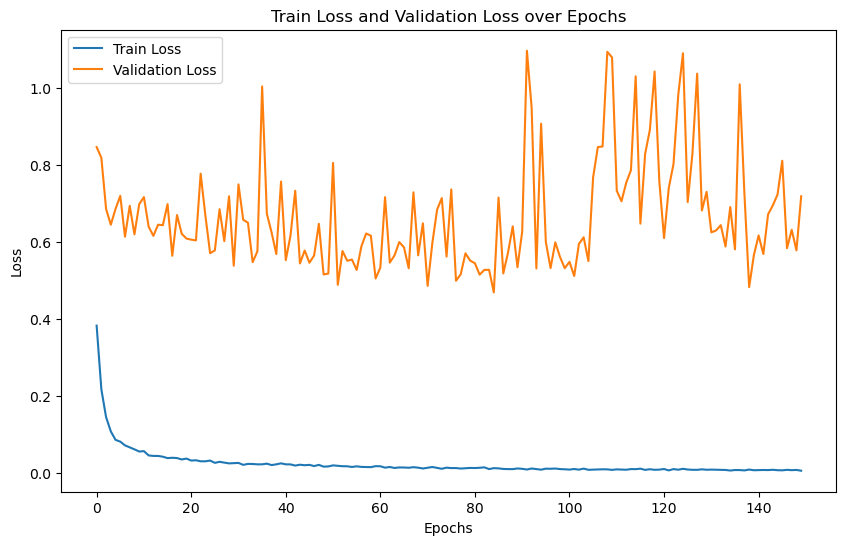

In [22]:
import csv

# 创建一个CSV文件，并初始化列名
with open("losses.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train_Loss", "Valid_Loss"])

best_valid_loss = np.Inf

# 创建两个列表，用于存储每个时期的train_loss和valid_loss
train_losses = []
valid_losses = []

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)
    
    # 添加损失到列表中
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # 将损失值写入到CSV文件中
    with open("losses.csv", mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, train_loss, valid_loss])

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

# 绘制train_loss和valid_loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Train Loss and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Get Anchor Embeddings

In [23]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [24]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 107086/107086 [1:06:55<00:00, 26.66it/s]


In [25]:
df_enc.to_csv('database.csv', index = False)

# 如果想根据整个行去除重复项，则无需使用subset参数
df_enc = df_enc.drop_duplicates(keep='first')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,0_1198_22-10-20_C2_06.jpg,-12.129483,9.133194,-37.529823,-7.159592,-12.072909,-8.607340,6.592667,45.614342,-7.342650,...,9.548835,17.444988,25.819838,19.470104,4.130705,-14.830169,-23.338137,4.058383,-82.336288,38.022106
12,0_1797_22-10-20_C2_06.jpg,-12.152112,9.084558,-37.612999,-7.158087,-12.095461,-8.661146,6.602045,45.659935,-7.522080,...,9.572988,17.577477,25.919607,19.432468,4.140319,-14.938423,-23.379799,4.109490,-82.354805,38.092167
23,0_2396_22-10-20_C2_06.jpg,-12.256198,8.907704,-37.422253,-6.836540,-12.073499,-8.643227,6.620775,45.460789,-7.419706,...,9.415309,17.555170,25.463884,19.399593,4.109156,-14.929287,-23.200705,4.067175,-81.923271,37.563274
34,0_2995_22-10-20_C2_06.jpg,-12.290776,9.022570,-37.640648,-6.857625,-12.228581,-8.749384,6.705318,45.651142,-7.373292,...,9.421353,17.638828,25.569498,19.565176,4.209355,-15.020256,-23.335382,4.087512,-82.076271,37.926571
44,0_3594_22-10-20_C2_06.jpg,-12.264404,8.950119,-37.640865,-6.922322,-12.037576,-8.704763,6.707074,45.600159,-7.661898,...,9.544498,17.637236,25.745207,19.450497,4.165078,-14.937757,-23.321913,4.125860,-82.136253,37.868797


# Inference

In [26]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [27]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [28]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [29]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [30]:
closest_idx = np.argsort(distance)

In [31]:
import networkx as nx
from skimage import io
import matplotlib.pyplot as plt

def plot_closest_imgs(anc_img_names, DATA_DIR, image, img_path, closest_idx, distance, no_of_closest=10):
    G = nx.Graph()

    # Since the DATA_DIR is already in img_path, we don't need to add it again.
    # Also, we're adapting to the new path format (using backslashes)
    S_name = [img_path.split('\\')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i in range(len(S_name)):
        # Since the DATA_DIR is already in img_path, we don't need to add it again.
        image = io.imread(DATA_DIR + S_name[i])

        G.add_node(i, image=image)

    for j in range(1, no_of_closest + 1):
        G.add_edge(0, j, weight=distance[closest_idx[j-1]])

    pos = nx.kamada_kawai_layout(G)

    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G, pos, ax=ax)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1  # this is the image size
    p2 = piesize / 2.0
    for n in G:
        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa-p2, ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n])
        a.axis('off')
    ax.axis('off')
    plt.show()


c:\Users\slu810\AppData\Local\anaconda3\envs\extract\Lib\site-packages\networkx\drawing\layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


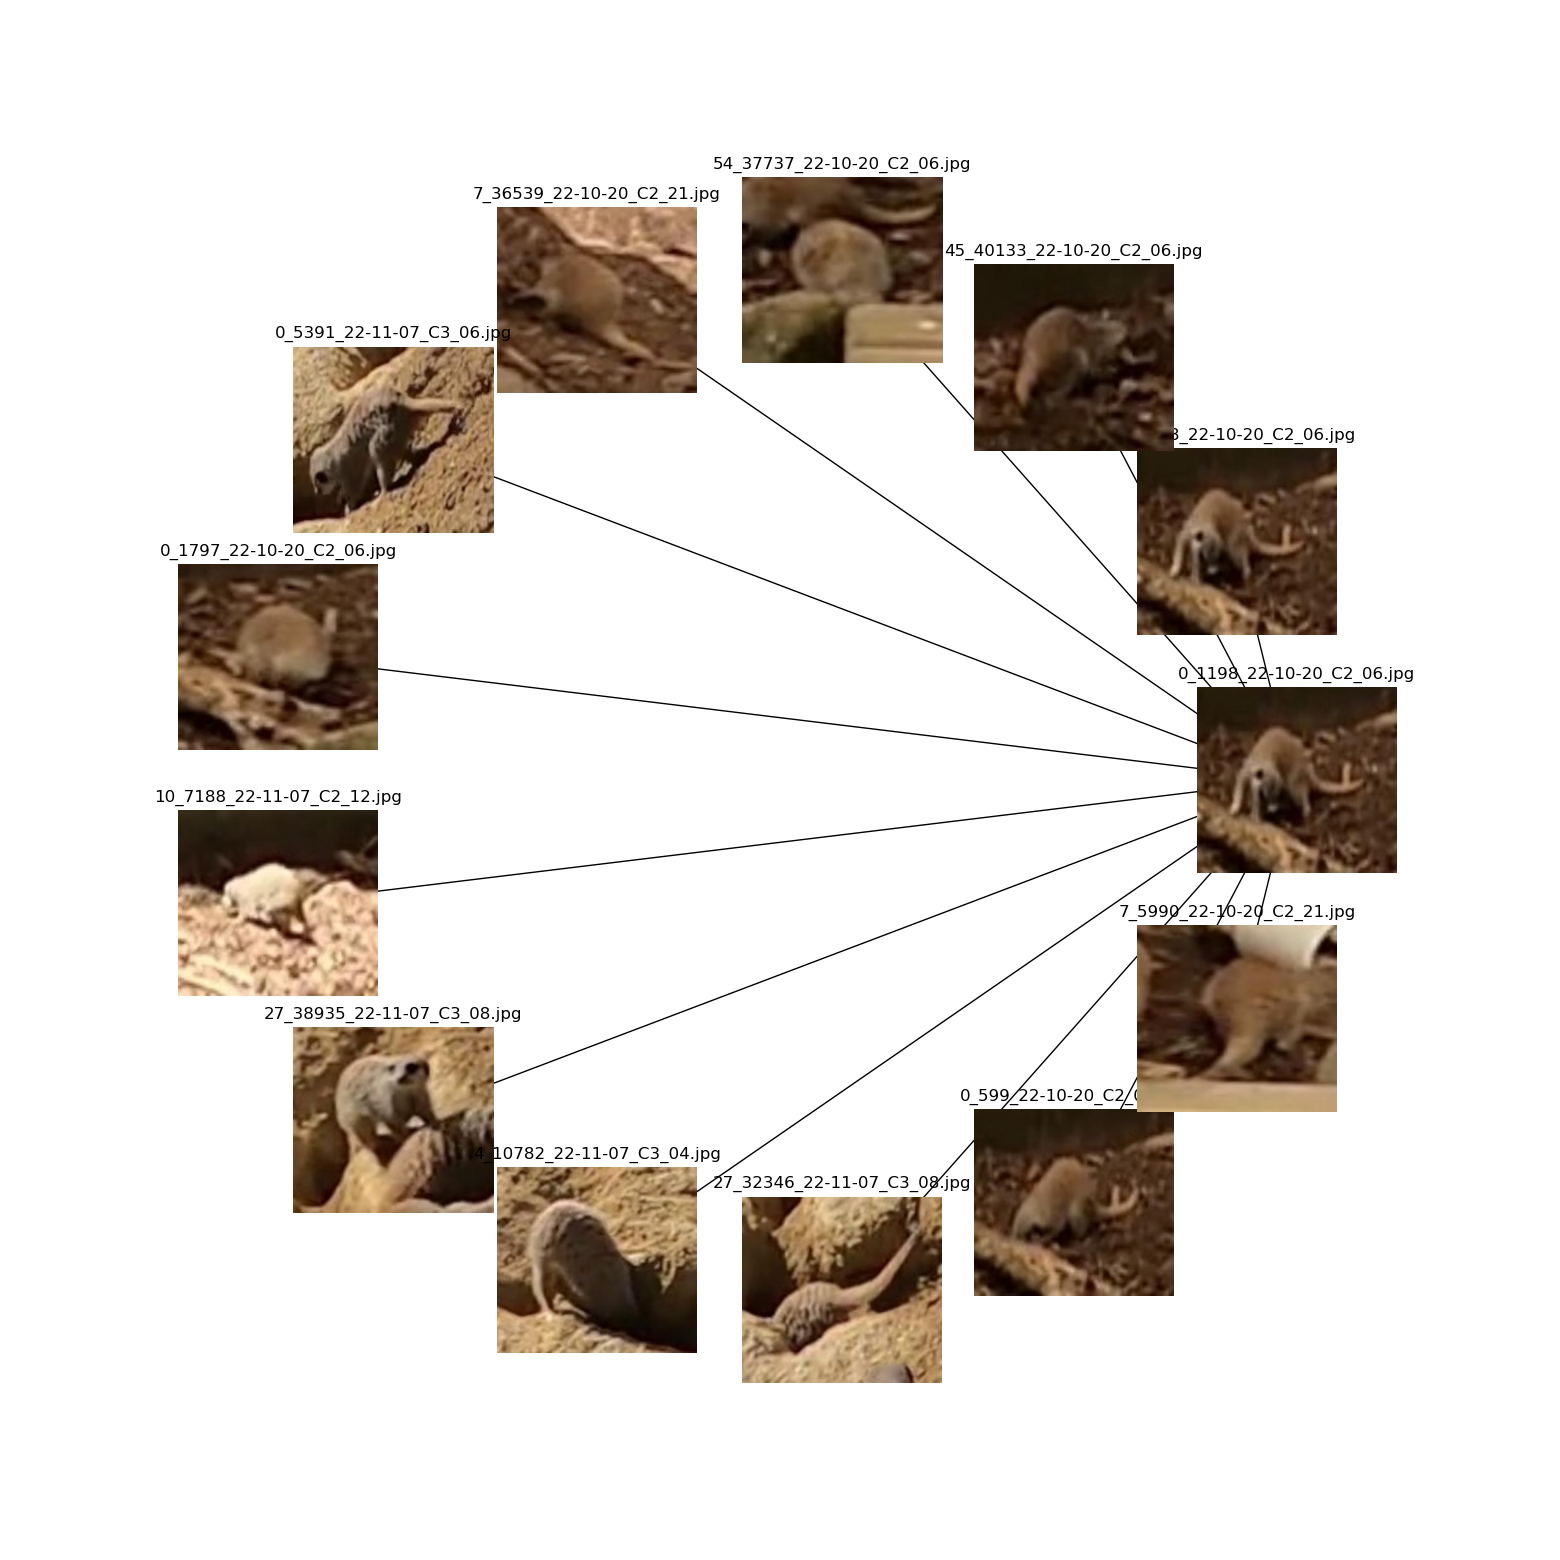

In [32]:
#from utils import plot_closest_imgs


plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 12);